In [2]:
library("geosphere")
library("ggplot2")
library("igraph", warn.conflicts = FALSE)

In [3]:
nodes <- read.csv("ITA_nodes.csv")
edges <- read.csv("ITA_edges.csv")

cat(sprintf("Columns nodes:"), colnames(nodes))
cat(sprintf("\nColumns edges:"), colnames(edges))

Columns nodes: adm_id population adm_name adm_code lat lon nuts3 GDPpc urbn_type
Columns edges: from to length_km estimated_flow

In [4]:
nodes$lat <- as.numeric(nodes$lat)
nodes$lon <- as.numeric(nodes$lon)

# Order nodes by adm_id, then update rownames
# (now each rowname is equal to the adm_id)

nodes <- nodes[order(nodes$adm_id), ]
rownames(nodes) <- nodes$adm_id

In [5]:
cat(sprintf("Order of magnitude of the estimated flows of people in the data:"),
    sum(edges$estimated_flow) * 1e-6, sprintf("millions."))

pol_edges <- edges[which(edges$from != edges$to & edges$estimated_flow > 0), ]
cat(sprintf("\nOrder of magnitude of the estimated flows of people in the data, without considering self-loops and edges with 0 flow:"), # nolint
    sum(pol_edges$estimated_flow) * 1e-6, sprintf("millions."))

Order of magnitude of the estimated flows of people in the data: 57.57352 millions.
Order of magnitude of the estimated flows of people in the data, without considering self-loops and edges with 0 flow: 4.427521 millions.

In [7]:
# length_km is already the distance between nodes in the edges dataset. We want
# check wether if they are correctly computed (using lat and lon), so we use the
# Haversine distance method from geospehere (converted in km).

edges$haversine <- 1e-3 * distHaversine(cbind(nodes[edges$from, ]$lon, nodes[edges$from, ]$lat),  
                                        cbind(nodes[edges$to, ]$lon, nodes[edges$to, ]$lat))

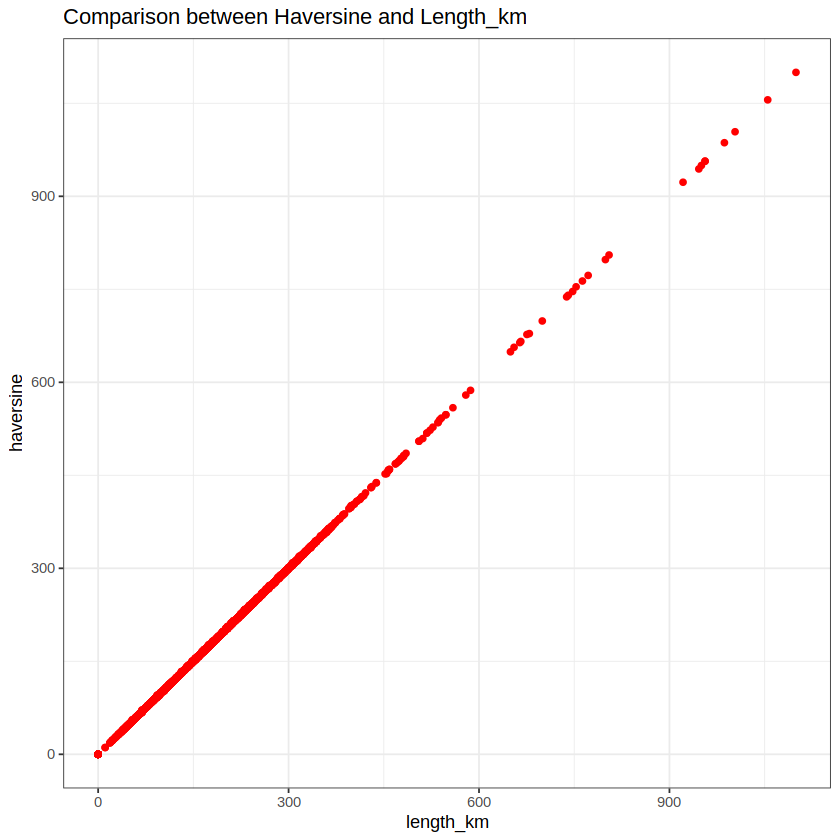

In [8]:
# Now we plot the two length, we expect a y = x line

ggplot(edges, aes(x = length_km, y = haversine)) +
  theme_bw() +
  geom_point(color = "red", size = 1.5) +
  labs(title = "Comparison between Haversine and Length_km",
       x = "length_km",
       y = "haversine")

In [ ]:
distancies <- matrix(0, nrow = nrow(nodes), ncol = nrow(nodes))

for (i in 1:nrow(nodes)) {
  for (j in 1:nrow(nodes)) {
    distancies[i, j] <- distHaversine(c(nodes$lon[i], nodes$lat[i]), c(nodes$lon[j], nodes$lat[j]))
  }
}

In [ ]:
g <- graph_from_data_frame(dat_edges[,c("from", "to")], directed=T, vertices=sort(dat_nodes$adm_id))
E(g)$weight <- dat_edges$estimated_flow
V(g)$pop <- dat_nodes$population
V(g)$label <- dat_nodes$adm_name

In [ ]:
layout <- matrix(NA, nrow(dat_nodes), 2)
layout[,1] <- dat_nodes$lon
layout[,2] <- dat_nodes$lat

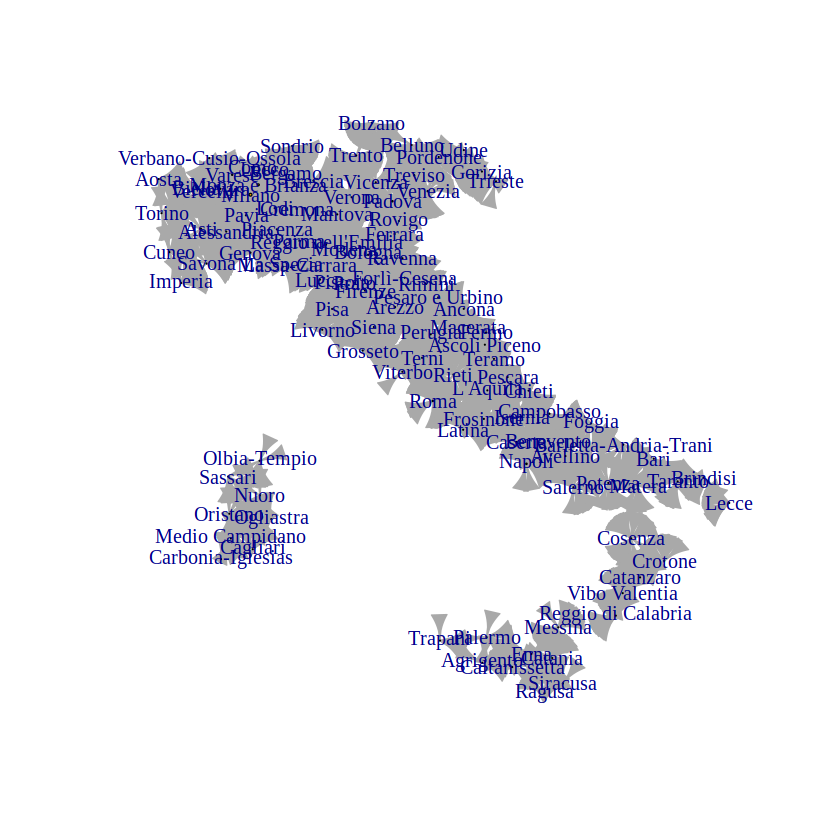

In [ ]:
sizes_nodes <- sqrt(strength(g, mode="all"))
sizes_edges <- E(g)$weight

plot(g, layout=layout, vertex.size=sizes_nodes/max(sizes_nodes), edge.width=sizes_edges/max(sizes_edges))

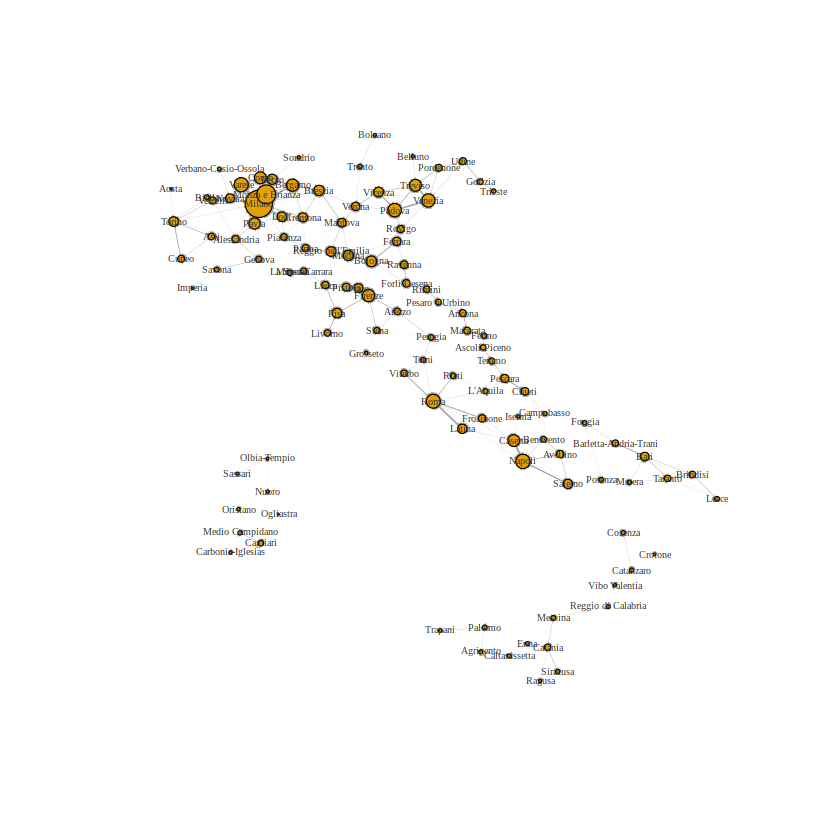

In [ ]:
plot(g, layout=layout, vertex.label=V(g)$label, vertex.label.cex=.5, vertex.label.color="gray20", vertex.size=10*sizes_nodes/max(sizes_nodes), edge.arrow.size=0.05, edge.arrow.width=0.05, edge.width=5*sizes_edges/max(sizes_edges))

In [ ]:
vec2pal <- function(x, palette) {
    n <- length(palette)
    max_x <- max(x)
    min_x <- min(x)
    idx <- floor((x - min_x) / (max_x - min_x) * (n - 1)) + 1
    return(palette[idx])
}


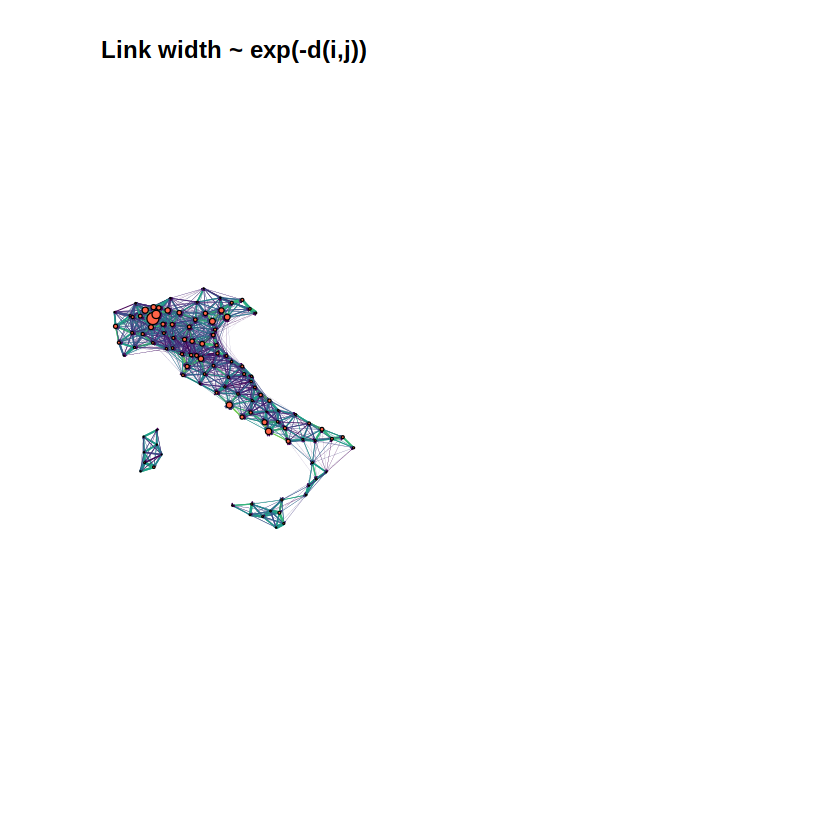

In [ ]:
mypal <- viridis::viridis_pal()(10)

par(mfrow=c(1,2))

w <- log10(E(g)$weight)
edge_colors <- vec2pal(w, mypal)
sizes_edges <- exp(-dat_edges$haversine/40)

plot(g, layout=layout, 
        vertex.label=NA, 
        vertex.label.cex=.5, 
        vertex.label.color="gray20", 
        vertex.color="tomato",
        vertex.size=10*sizes_nodes/max(sizes_nodes), 
        edge.arrow.size=0.05, 
        edge.arrow.width=0.05, 
        edge.width=5*sizes_edges/max(sizes_edges), 
        edge.color=edge_colors,
        main="Link width ~ exp(-d(i,j))")

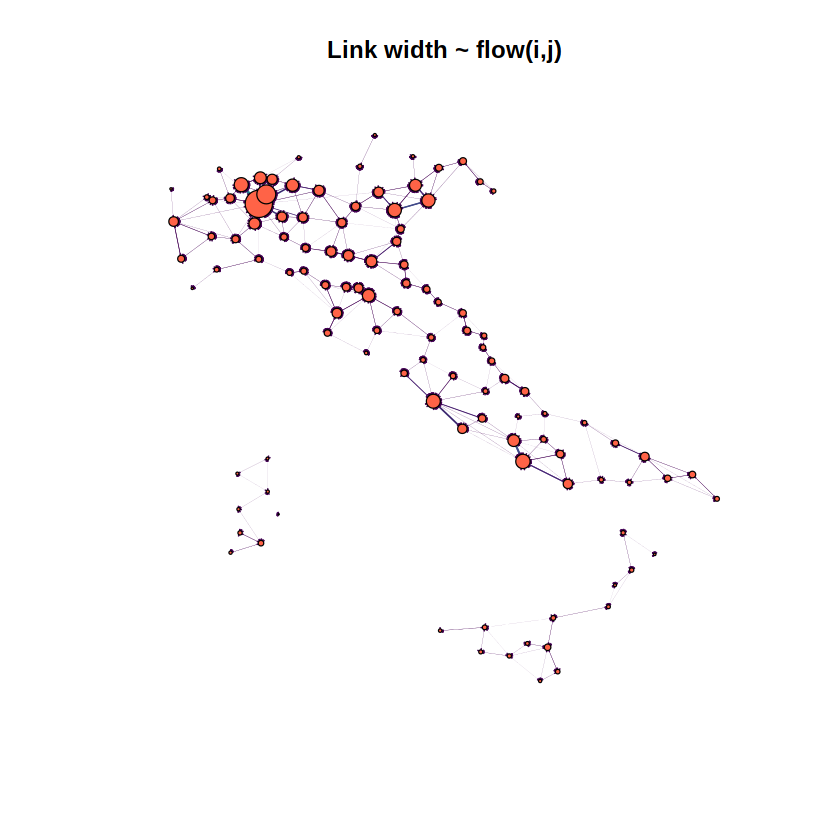

In [ ]:
w <- E(g)$weight
edge_colors <- vec2pal(w, mypal)
sizes_edges <- w

plot(g, layout=layout,
        vertex.label=NA,
        vertex.label.cex=.5,
        vertex.label.color="gray20",
        vertex.color="tomato",
        vertex.size=10*sizes_nodes/max(sizes_nodes),
        edge.arrow.size=0.05,
        edge.arrow.width=0.05,
        edge.width=5*sizes_edges/max(sizes_edges), 
        edge.color=edge_colors,
        main="Link width ~ flow(i,j)")

In [ ]:
flows <- matrix(0, nrow = nrow(nodes), ncol = nrow(nodes))

for (i in 1:nrow(nodes)) {
  for (j in 1:nrow(nodes)) {
    # Subset edges data frame to get estimated flow from node i to node j
    matched_edges <- edges$estimated_flow[edges$from == i & edges$to == j]
    
    # Check if there are any matches
    if (length(matched_edges) > 0) {
      # If matches found, assign the first value to flows[i, j]
      flows[i, j] <- matched_edges[1]
    } else {
      flows[i, j] <- 0
    }
  }
}
flows

2218505.86,6277.14,1773.38,16415.08,7116.42,1949.18,3943.90,34.16,146.94,305.16,⋯,0,0,99.60,0,0,0,0,215.38,0,0
9238.94,136617.76,9628.72,71.62,220.82,3615.74,82.68,0.00,16.10,45.38,⋯,0,0,120.80,0,0,0,0,77.26,0,0
1491.56,8696.96,320654.04,29.76,363.46,508.40,17.52,19.84,8.00,28.86,⋯,0,0,4526.60,0,0,0,0,585.46,0,0
26007.20,35.46,56.46,580066.12,3858.78,390.76,18.00,247.50,1729.02,229.92,⋯,0,0,6.00,0,0,0,0,12.00,0,0
18231.92,234.98,84.16,9229.00,176490.08,7472.30,27.38,17.62,115.74,222.82,⋯,0,0,10.00,0,0,0,0,10.00,0,0
3974.58,2691.50,636.54,459.34,5408.74,364341.74,15.42,25.98,826.84,10055.20,⋯,0,0,24.90,0,0,0,0,108.72,0,0
2071.72,36.42,16.20,10.00,8.00,90.36,130917.88,2.00,0.00,4.02,⋯,0,0,0.00,0,0,0,0,8.00,0,0
102.72,0.00,8.00,153.80,4.00,17.52,0.00,179121.90,2786.02,608.12,⋯,0,0,0.00,0,0,0,0,4.00,0,0
392.76,10.00,26.00,1638.62,72.36,583.02,0.00,2647.56,237285.68,11524.68,⋯,0,0,2.00,0,0,0,0,10.00,0,0
334.62,56.88,34.66,440.22,162.14,5466.70,10.28,220.62,6113.28,804170.54,⋯,0,0,2.00,0,0,0,0,54.76,0,0
24.22,8.00,5.16,18.58,0.00,10.00,0.00,14.32,26.16,3761.52,⋯,0,0,4.00,0,0,0,0,12.90,0,0


In [ ]:
GravityModel <- function(i, j, alpha, beta, k, d0){
  num <- nodes$population[i]^alpha * nodes$population[j]^beta
  den <- exp(distancies[i, j]/d0)

  return (k * num / den)
}

GravityModel(1, 5, 0.5, 1, 0.005, 10000)

[1] 2219.575

In [ ]:
# Define loss function
loss_function <- function(params) {
  loss <- 0
  
  for (i in 1:nrow(nodes)) {
    for (j in 1:ncol(nodes)) {
      predicted_flow <- GravityModel(i, j, alpha = params[1], beta = params[2], k = params[3], d0 = params[4])
      loss <- loss + (flows[i, j] - predicted_flow)^2
    }
  }
  
  return(loss)
}

# Initial guess for parameters
initial_params <- c(0.5, 0.5, 0.005, 10000)

# Minimize the loss function using optim
optimal_params <- optim(initial_params, loss_function)$par
optimal_params

[1] 5.875801e-02 9.942262e-01 4.529480e-01 1.099584e+04

In [ ]:
real_flows <- matrix(0, nrow = nrow(nodes), ncol = nrow(nodes))

for (i in 1:nrow(nodes)) {
  for (j in 1:ncol(nodes)) {
    real_flows[i, j] <- GravityModel(i, j, alpha = optimal_params[1], beta = optimal_params[2], k = optimal_params[3], d0 = optimal_params[4])
  }
}

In [ ]:
# Filter out negative or NA estimated_flow values

# Determine breaks for quantiles
breaks <- quantile(dat_edges$estimated_flow, probs = seq(0, 1, length.out = 11))

# Define a function to generate the color palette
color_palette <- colorRampPalette(c("lightblue", "darkred"))

# Assign colors to quantiles
quantile_colors <- color_palette(10)

# Create a new column in edges_filtered for color groups
edges_filtered$color_group <- cut(dat_edges$estimated_flow, breaks = breaks, labels = FALSE)

# Combine plots
combined_plot <- ggplot() +
  geom_segment(data = dat_edges, aes(x = dat_nodes$lon[from], y = dat_nodes$lat[from],
                                          xend = dat_nodes$lon[to], yend = dat_nodes$lat[to], color = factor(color_group)), 
               size = 0.5) + 
  geom_point(data = dat_nodes, aes(x = lon, y = lat), color = "blue", size = 2) +  # Plot dat_nodes
  labs(x = "Longitude", y = "Latitude", title = "dat_nodes and Edges") +  # Set axis labels and title
  scale_color_manual(name = "Flow Quantile", values = quantile_colors) +  # Assign colors to quantiles
  guides(color = guide_legend(title = "Flow Quantile"))  # Set legend title

# Display combined plot
print(combined_plot)

ERROR: Error in cut.default(dat_edges$estimated_flow, breaks = breaks, labels = FALSE): 'breaks' are not unique


In [ ]:
RadiationModel <- function(i, j, alpha, beta, k, d0){
  num <- nodes$population[i]^alpha * nodes$population[j]^beta
  den <- exp(distancies[i, j]/d0)

  return (k * num / den)
}

RadiationModel(1, 5, 0.5, 1, 0.005, 10000)

[1] 2219.575